# Produce national and municipal measures as Rt and CFR 

In [1]:
from math import exp

import epyestim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from epyestim import covid19
from scipy.stats import gamma, lognorm

## Loading data

In [9]:
df_monitoring_panel_national = pd.read_csv('data/output/df_ts_monitoring_panel_treated_national.csv')
df_sim_national = pd.read_csv('data/output/df_sim_national.csv')

In [10]:
df_monitoring_panel_national.data = pd.to_datetime(df_monitoring_panel_national.data, infer_datetime_format=True)
df_sim_national.DATA = pd.to_datetime(df_sim_national.DATA, infer_datetime_format=True)

In [11]:
df_monitoring_panel_national = df_monitoring_panel_national.rename(columns={'data': 'DATA'})

In [12]:
df_monitoring_panel_national = df_monitoring_panel_national.rename(columns={'obitosNovos':'OBITOS_NOVOS_PAINEL', 'obitosAcumulado': 'OBITOS_ACUMULADO_PAINEL', 'casosNovos':'CASOS_NOVOS_PAINEL', 'casosAcumulado': 'CASOS_ACUMULADO_PAINEL', 'CASOS_NOVOS_MEDIA_MOVEL_7_DIAS': 'CASOS_NOVOS_MEDIA_MOVEL_7_DIAS_PAINEL', 'OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS': 'OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS_PAINEL'})

In [13]:
df_sim_national = df_sim_national.rename(columns={'OBITOS_NOVOS':'OBITOS_NOVOS_SIM', 'OBITOS': 'OBITOS_ACUMULADO_SIM', 'OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS':'OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS_SIM', 'TAXA_OBITOS_NOVOS': 'TAXA_OBITOS_NOVOS_SIM', 'TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS': 'TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS_SIM', 'TAXA_OBITOS': 'TAXA_OBITOS_SIM'}) 

In [14]:
df_sim_national = df_sim_national.drop(columns=['day_of_week'])

In [15]:
df_national = df_monitoring_panel_national.merge(df_sim_national, how='outer', on='DATA')

In [16]:
df_national = df_national.fillna(0)

In [17]:
df_srag_national = pd.read_csv('data/output/df_ts_srag_national.csv')

In [18]:
df_srag_national.DATA = pd.to_datetime(df_srag_national.DATA, infer_datetime_format=True)
df_srag_national = df_srag_national.rename(columns={'NOVOS_CASOS': 'NOVOS_CASOS_SRAG', 'NOVOS_OBITOS':'NOVOS_OBITOS_SRAG'})

In [19]:
df_national = df_national.merge(df_srag_national, on='DATA', how='outer')

In [20]:
df_national = df_national.fillna(0)

In [21]:
df_national = df_national.sort_values('DATA')

## Estimating effective reproduction number for national time series


In [22]:
#Bi, Qifang, et al. "Epidemiology and transmission of COVID-19 in 391 cases and 1286 of their close contacts in Shenzhen, China: a retrospective cohort study." The Lancet infectious diseases 20.8 (2020): 911-919.
# Gamma distribution with serial interval mean equal to 6.36 days, gamma(a=2.29, b=0.36)
standard_serial_inteval_distribution = epyestim.discrete_distrb(gamma(a=2.29, scale=1/0.36))

#Bi, Qifang, et al. "Epidemiology and transmission of COVID-19 in 391 cases and 1286 of their close contacts in Shenzhen, China: a retrospective cohort study." The Lancet infectious diseases 20.8 (2020): 911-919.
# Lognormal distribution with incabation mean equal to 5.93 days, Lognormal(mu=1.57, sigma²=0.42)
incubation_time_distribution = epyestim.discrete_distrb(lognorm(scale=exp(1.57), s=0.65))

# Chagas, Eduarda TC, et al. "Effects of population mobility on the COVID-19 spread in Brazil." PloS one 16.12 (2021): e0260610.
# Exponential distribution with delay mean equal to 10.85 days, gamma(a=12.26, b=1.13)
# Tip to calulate parameters: https://www.quora.com/How-can-I-calculate-a-gamma-distribution-using-mean-and-SD
# delay_onset_to_notification_distribution = epyestim.discrete_distrb(gamma(a=12.26, scale=1/1.13))

#Barros, Gabriela Pereira, et al. "Estimation of Reproduction Number for Covid-19 with Statistical Correction of Notifications Delay." IEEE Latin America Transactions 20.7 (2022): 1085-1091.
#Gamma distribution for BH city with mean equal 6.56 days SD 5.34, gamma(a=1.51, b=0.23)
delay_onset_to_notification_distribution = epyestim.discrete_distrb(gamma(a=1.51, scale=1/0.23))

# Distribution resultant of convolution incubation_time_distribution and delay_onset_to_notification_distribution.
# Represent delay of infection to notification with delay mean equal to 12.5 days.
delay_infecton_to_notification_distribution = np.convolve(incubation_time_distribution, delay_onset_to_notification_distribution)

# Verity, Robert, et al. "Estimates of the severity of coronavirus disease 2019: a model-based analysis." The Lancet infectious diseases 20.6 (2020): 669-677.
# Gamma distribution with delay mean equal to 18.8 days
mean_days_delay_onset_to_death = 18.8  # mean days onset to death.
s_death = 0.45
shape_death = 1/(s_death**2)
scale_death= mean_days_delay_onset_to_death * s_death ** 2
delay_onset_to_death_distribution = epyestim.discrete_distrb(gamma(a=shape_death, scale=scale_death))

# Distribution resultant of convolution incubation_time_distribution and delay_onset_to_notification_distribution.
# Represent delay of infection to notification with delay mean equal to 24.02 days.
delay_infecton_to_death_distribution = np.convolve(incubation_time_distribution, delay_onset_to_death_distribution)

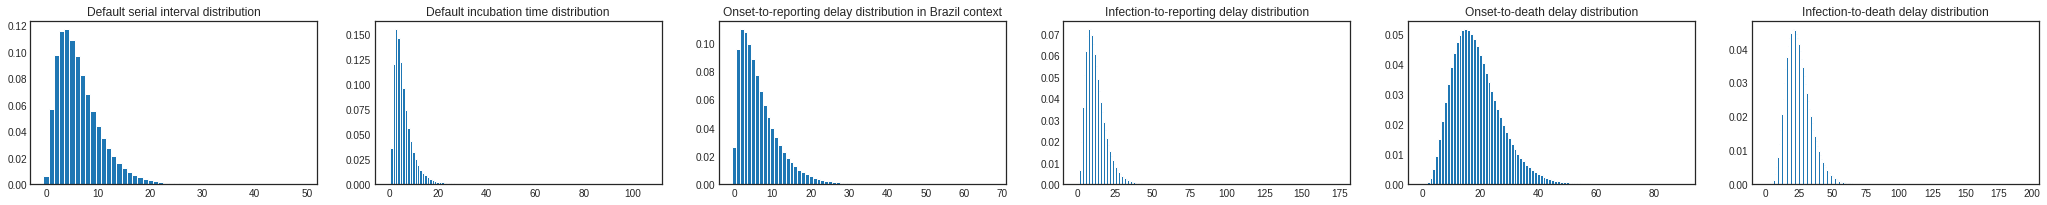

In [23]:
fig, axs = plt.subplots(1, 6, figsize=(36,3))

axs[0].bar(range(len(standard_serial_inteval_distribution)), standard_serial_inteval_distribution, width=1)
axs[1].bar(range(len(incubation_time_distribution)), incubation_time_distribution, width=1)
axs[2].bar(range(len(delay_onset_to_notification_distribution)), delay_onset_to_notification_distribution, width=1)
# axs[3].bar(range(50), delay_infecton_to_notification_distribution[:50], width=1)
axs[3].bar(range(len(delay_infecton_to_notification_distribution)), delay_infecton_to_notification_distribution, width=1)
axs[4].bar(range(len(delay_onset_to_death_distribution)), delay_onset_to_death_distribution, width=1)
axs[5].bar(range(len(delay_infecton_to_death_distribution)), delay_infecton_to_death_distribution, width=1)

axs[0].set_title('Default serial interval distribution')
axs[1].set_title('Default incubation time distribution')
axs[2].set_title('Onset-to-reporting delay distribution in Brazil context')
axs[3].set_title('Infection-to-reporting delay distribution')
axs[4].set_title('Onset-to-death delay distribution')
axs[5].set_title('Infection-to-death delay distribution')
plt.show()

In [24]:
window_days_onset_to_death = round(mean_days_delay_onset_to_death)
window_days_onset_to_death

19

In [25]:
survival_rate = (df_national.CASOS_NOVOS_PAINEL.sum() / df_national.OBITOS_NOVOS_SIM.sum())
survival_rate

51.7129300540739

### National data

In [26]:
df_national_temp = df_national.copy() 
df_national_temp.loc[df_national_temp.CASOS_NOVOS_PAINEL < 0, 'CASOS_NOVOS_PAINEL'] = 0
df_cases = df_national_temp.set_index('DATA')['CASOS_NOVOS_PAINEL']

In [27]:
# Cori, A., Ferguson, N. M., Fraser, C., & Cauchemez, S. (2013). A new framework and software to estimate time-varying reproduction numbers during epidemics. American journal of epidemiology, 178(9), 1505-1512.
# https://github.com/lo-hfk/epyestim
df_effective_reproduction_number = covid19.r_covid(df_cases, smoothing_window = 28, r_window_size = 14, auto_cutoff=True, n_samples=100, delay_distribution=delay_infecton_to_notification_distribution, gt_distribution=standard_serial_inteval_distribution, a_prior=9.9, b_prior=1/9.25)

In [28]:
df_national['CASOS_INICIO_SINTOMAS_ESTIMADOS'] = df_national['OBITOS_NOVOS_SIM'] * survival_rate
df_national['CASOS_INICIO_SINTOMAS_ESTIMADOS'] = df_national['CASOS_INICIO_SINTOMAS_ESTIMADOS'].rolling(window=window_days_onset_to_death, min_periods=1).mean().shift(-(window_days_onset_to_death - 1))

In [29]:
df_estimated_cases = df_national.set_index('DATA')['CASOS_INICIO_SINTOMAS_ESTIMADOS'].dropna()

In [30]:
df_effective_reproduction_number_estimated_cases = covid19.r_covid(df_estimated_cases, smoothing_window = 28, r_window_size = 14, auto_cutoff=True, n_samples=100, delay_distribution=incubation_time_distribution, gt_distribution=standard_serial_inteval_distribution, a_prior=9.9, b_prior=1/9.25)

In [31]:
df_cases_srag = df_national.set_index('DATA')['NOVOS_CASOS_SRAG']

In [32]:
df_effective_reproduction_number_srag = covid19.r_covid(df_cases_srag, smoothing_window = 28, r_window_size = 14, auto_cutoff=True, n_samples=100, delay_distribution=incubation_time_distribution, gt_distribution=standard_serial_inteval_distribution, a_prior=9.9, b_prior=1/9.25)

In [33]:
df_effective_reproduction_number = df_effective_reproduction_number.reset_index()
df_effective_reproduction_number = df_effective_reproduction_number.rename(columns={'index': 'DATA', 'R_mean': 'NUMERO_REPRODUCAO_EFETIVO_MEDIA', 'R_var': 'NUMERO_REPRODUCAO_EFETIVO_VARIANCIA', 'Q0.025': 'NUMERO_REPRODUCAO_EFETIVO_QUANTIL_0.025', 'Q0.5': 'NUMERO_REPRODUCAO_EFETIVO_MEDIANA', 'Q0.975': 'NUMERO_REPRODUCAO_EFETIVO_QUANTIL_0.975' })
df_effective_reproduction_number = df_effective_reproduction_number.drop(columns=['cases'])
df_national = df_national.merge(df_effective_reproduction_number, how='left', left_on='DATA', right_on='DATA')

In [34]:
df_effective_reproduction_number_estimated_cases = df_effective_reproduction_number_estimated_cases.reset_index()
df_effective_reproduction_number_estimated_cases = df_effective_reproduction_number_estimated_cases.rename(columns={'index': 'DATA', 'R_mean': 'NUMERO_REPRODUCAO_EFETIVO_ATRASADO_MEDIA', 'R_var': 'NUMERO_REPRODUCAO_EFETIVO_ATRASADO_VARIANCIA', 'Q0.025': 'NUMERO_REPRODUCAO_EFETIVO_ATRASADO_QUANTIL_0.025', 'Q0.5': 'NUMERO_REPRODUCAO_EFETIVO_ATRASADO_MEDIANA', 'Q0.975': 'NUMERO_REPRODUCAO_EFETIVO_ATRASADO_QUANTIL_0.975' })
df_effective_reproduction_number_estimated_cases = df_effective_reproduction_number_estimated_cases.drop(columns=['cases'])
df_national = df_national.merge(df_effective_reproduction_number_estimated_cases, how='left', left_on='DATA', right_on='DATA')

In [35]:
df_effective_reproduction_number_srag = df_effective_reproduction_number_srag.reset_index()
df_effective_reproduction_number_srag = df_effective_reproduction_number_srag.rename(columns={'index': 'DATA', 'R_mean': 'NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIA', 'R_var': 'NUMERO_REPRODUCAO_EFETIVO_SRAG_VARIANCIA', 'Q0.025': 'NUMERO_REPRODUCAO_EFETIVO_SRAG_QUANTIL_0.025', 'Q0.5': 'NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIANA', 'Q0.975': 'NUMERO_REPRODUCAO_EFETIVO_SRAG_QUANTIL_0.975' })
df_effective_reproduction_number_srag = df_effective_reproduction_number_srag.drop(columns=['cases'])
df_national = df_national.merge(df_effective_reproduction_number_srag, how='left', left_on='DATA', right_on='DATA')

In [36]:
df_national['POPULACAO_2022'] = df_national['POPULACAO_2022'].max()

## Case fatality rate

### National data

In [38]:
df_national.columns

Index(['DATA', 'estado', 'municipio', 'CODIGO_MUNICIPIO_6',
       'OBITOS_NOVOS_PAINEL', 'OBITOS_ACUMULADO_PAINEL', 'CASOS_NOVOS_PAINEL',
       'CASOS_ACUMULADO_PAINEL', 'day_of_week',
       'CASOS_NOVOS_MEDIA_MOVEL_7_DIAS_PAINEL',
       'OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS_PAINEL', 'OBITOS_NOVOS_SIM',
       'OBITOS_ACUMULADO_SIM', 'OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS_SIM',
       'POPULACAO_2022', 'TAXA_OBITOS_NOVOS_SIM',
       'TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS_SIM', 'TAXA_OBITOS_SIM',
       'NOVOS_CASOS_SRAG', 'NOVOS_OBITOS_SRAG',
       'CASOS_INICIO_SINTOMAS_ESTIMADOS', 'NUMERO_REPRODUCAO_EFETIVO_MEDIA',
       'NUMERO_REPRODUCAO_EFETIVO_VARIANCIA',
       'NUMERO_REPRODUCAO_EFETIVO_QUANTIL_0.025',
       'NUMERO_REPRODUCAO_EFETIVO_MEDIANA',
       'NUMERO_REPRODUCAO_EFETIVO_QUANTIL_0.975',
       'NUMERO_REPRODUCAO_EFETIVO_ATRASADO_MEDIA',
       'NUMERO_REPRODUCAO_EFETIVO_ATRASADO_VARIANCIA',
       'NUMERO_REPRODUCAO_EFETIVO_ATRASADO_QUANTIL_0.025',
       'NUMERO_REPRODUCAO_

In [43]:
df_national['TAXA_FATALIDADE'] = df_national.OBITOS_NOVOS_SIM / df_national.CASOS_NOVOS_MEDIA_MOVEL_7_DIAS_PAINEL.shift(12) * 100

df_national['NOVOS_OBITOS_MEDIA_MOVEL_7_DIAS_SRAG'] = df_national.NOVOS_OBITOS_SRAG.rolling(7, min_periods=1).mean()
df_national['NOVOS_CASOS_MEDIA_MOVEL_7_DIAS_SRAG'] = df_national.NOVOS_CASOS_SRAG.rolling(7, min_periods=1).mean()
df_national['TAXA_FATALIDADE_SRAG'] = df_national.NOVOS_OBITOS_MEDIA_MOVEL_7_DIAS_SRAG / df_national.NOVOS_CASOS_MEDIA_MOVEL_7_DIAS_SRAG.shift(12) * 100

## Saving data


In [45]:
df_national.to_csv('data/output/df_national.csv')

In [46]:
df_national

,DATA,OBITOS_NOVOS_PAINEL,OBITOS_ACUMULADO_PAINEL,CASOS_NOVOS_PAINEL,CASOS_ACUMULADO_PAINEL,day_of_week,CASOS_NOVOS_MEDIA_MOVEL_7_DIAS_PAINEL,OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS_PAINEL,OBITOS_NOVOS_SIM,OBITOS_ACUMULADO_SIM,...,NUMERO_REPRODUCAO_EFETIVO_ATRASADO_QUANTIL_0.975,NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIA,NUMERO_REPRODUCAO_EFETIVO_SRAG_VARIANCIA,NUMERO_REPRODUCAO_EFETIVO_SRAG_QUANTIL_0.025,NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIANA,NUMERO_REPRODUCAO_EFETIVO_SRAG_QUANTIL_0.975,TAXA_FATALIDADE,TAXA_FATALIDADE_SRAG,NOVOS_OBITOS_MEDIA_MOVEL_7_DIAS_SRAG,NOVOS_CASOS_MEDIA_MOVEL_7_DIAS_SRAG
0,2020-02-16,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,5.000000
1,2020-02-17,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,7.500000
2,2020-02-18,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,7.666667
3,2020-02-19,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,7.000000
4,2020-02-20,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,2022-12-27,230.0,693199.0,35898.0,36226287.0,1.0,32075.285714,131.285714,126.0,702158.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.317134,18.354832,124.000000,470.142857
1046,2022-12-28,363.0,693562.0,38434.0,36264721.0,2.0,31468.571429,157.285714,102.0,702260.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.211361,18.059182,118.571429,465.428571
1047,2022-12-29,172.0,693734.0,37694.0,36302415.0,3.0,29938.571429,154.571429,104.0,702364.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.226545,18.957897,116.428571,447.000000
1048,2022-12-30,119.0,693853.0,28866.0,36331281.0,4.0,29563.428571,158.571429,88.0,702452.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.189866,18.545888,111.142857,434.571429
